# Dataset creation for sign spotting
Here, we preprocess the data from the Corpus NGT and split it up by its annotations. The data corresponding to an annotation are then sampled so they are of a fixed length. 

If the target fixed length is X frames, we can check if an annotation is already X frames long. If so, we can simply add its (preprocessed) data as a new entry in the train, validation or test set. If instead the length of the annotation is less than X frames, we add zero padding. 

If the annotation is longer than X frames, we undersample the frames. For instance, assuming we have a target length X=10 and an annotation with 22 frames, we first drop every other (every second) frame to get to 11 frames. We do not use random undersampling here to ensure at least some of the temporal structure of the annotation is maintained. Then, we drop 1 more frame randomly to get to our target of 10 frames.

We first create the dataset using the above method, before repeating the 'dataset creation' for the purposes of checking the correlation between the used features. The repeat is needed because for the correlation analysis, we do not want to  undersampling and zero padding be done, we simply use the annotations at their original length. After preparing for the correlation analysis, we use masking of the NaN values to not skew the correlation (e.g. by replacing NaNs with zeros). Lastly, we find out which features have correlation above some threshold so we can discard them before training our sign spotting model.

In [1]:
# Imports
import pympi
import os
import numpy as np
import numpy.ma as ma
import pandas as pd
from sklearn import preprocessing

import importlib

# Keep python tools up to date
from tools import tools, feature_extraction, constants, mediapipe_tools, make_dataset
importlib.reload(mediapipe_tools)
importlib.reload(tools)
importlib.reload(constants)
importlib.reload(feature_extraction)
importlib.reload(make_dataset)

# Import all functions from the tools
from tools.tools import*
from tools.mediapipe_tools import normalise_coordinates, get_pixel_coordinates
from tools.constants import PATHS # Path constants
from tools.feature_extraction import get_wrist_angle_distance
from tools.make_dataset import make_dataset

np.random.seed(123) # Set random seed for consistency

In [2]:
# We find all of the landmark files, split up by the different areas
# E.g. 'face' has its own numpy file for each video
path = PATHS['np_landmarks']
cngt_lmrks = find_files(path, '.npy')
print('Number of CNGT files when split into numpy files:', len(cngt_lmrks))

Number of CNGT files when split into numpy files: 3420


In [3]:
# Root where all the annotated .eaf sign files are present
dataset_root = PATHS['cngt_vids_and_eaf']

# This is a path to a file of annotations tailored to the dataset creation
# It only distinguishes between handedness, not manual simultaneity
# Because we don't care about whether another sign is produced simultaneously
# For making the dataset, we only want to make sure two-handed signs
# Are added once as an annotation and not twice, so that's why we distinguish handedness
dataset_anns_path = PATHS['dataset_anns']

# List the .eaf files in the root directory to investigate
anns_in_dir = [file for file in os.listdir(dataset_root) if file.endswith('.eaf')]

# Loading the annotations for the dataset-tailored annotations
# Or we create them if they don't exist yet
if os.path.exists(dataset_anns_path):
    print('Loading annotations...')
    anns_with_tiers = load_dict(dataset_anns_path)
else:
    print('Making annotations without manual simultaneity...')
    anns_with_tiers = {}
    for i, ann_file in enumerate(anns_in_dir):
        print(i, end = '\r')
        # Read in the Eaf file 
        eaf_file = pympi.Elan.Eaf(os.path.join(dataset_root, ann_file))

        # Get the glosses and mouthings of the file
        anns_dict, _ = get_gloss_vals(eaf_file, True)
        # As explained above, we only distinguish handedness and not simultaneity
        anns_dict = man_sim_and_hand_dist(anns_dict, manual_sim = False)

        # Store the glosses, mouthings and tiers
        anns_with_tiers[ann_file] = anns_dict
    print('Storing...')
    with open(dataset_anns_path, 'wb') as f:
        pickle.dump(anns_with_tiers, f)
        
# Signbank dictionary info
df = pd.read_csv(PATHS['signbank_with_linguistics'])

# Dictionary which contains which videos (and signers) belong in test/train set
id_split = load_dict(PATHS['CNGT_split_ids'])

# Using only the top X signs if we have a list of them
top = -1
top_signs_path = PATHS['top_signs'].format(top)
if os.path.exists(top_signs_path):
    top_signs = np.load(top_signs_path)
else:
    top_signs = []

Loading annotations...


In [4]:
print('Signer split across train, validation and test sets')
# Printing which signers belong in the train, validation and test set
for key in id_split:
    print(key, sorted(set([x.split('_')[-1] for x in id_split[key]])))
# Note that the val and test sets are allowed to have the same signers (same Sxxx)
# But that they should contain different videos
val_vids = id_split['Val']
test_vids = id_split['Test']

Signer split across train, validation and test sets
Train ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S029', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S043', 'S044', 'S045', 'S049', 'S050', 'S059', 'S060', 'S061', 'S062', 'S063', 'S064', 'S065', 'S066', 'S067', 'S068', 'S069', 'S070', 'S075', 'S076', 'S077', 'S078', 'S083', 'S084', 'S087', 'S088', 'S089', 'S090', 'S091', 'S092']
Val ['S011', 'S012', 'S019', 'S020', 'S027', 'S028', 'S039', 'S040', 'S041', 'S045', 'S046', 'S047', 'S048', 'S051', 'S052', 'S055', 'S056', 'S058', 'S071', 'S072', 'S073', 'S074', 'S079', 'S080', 'S081', 'S082', 'S085', 'S086']
Test ['S011', 'S012', 'S019', 'S020', 'S027', 'S028', 'S039', 'S040', 'S041', 'S042', 'S045', 'S046', 'S047', 'S048', 'S051', 'S052', 'S053', 'S054', 'S055', 'S056', 'S057', 'S058', 'S071', 'S072', 'S073', 'S074', 'S080', 'S

# Data preprocessing and feature extraction
**Note:** this codeblock can take a while to run for the first time due to the preprocessing and extraction for each video being computationally heavy. 

*Expected runtime: 15-30min*

In [5]:
%%time
# Here we pick if we want to make a dataset with feature extraction (based on linguistics)
# Or if we want to just extract the landmarks (done if only_features = False)
only_features = True
features = '' if only_features else '_only_lmrks'

# Path where the extracted features are stored
features_path = PATHS['features_data'].format(features)

# If the extracted features are not saved yet, we create them and then store them
if not os.path.exists(features_path):
    print('Creating feature-extracted data...')
    features_data = {}
    for i, k in enumerate(anns_with_tiers):
        print('Extracting features for video {}/{}'.format(i+1, len(list(anns_with_tiers.keys()))), end = '\r')
        # Get the glosses of the file
        anns_dict = anns_with_tiers[k]
    
        # Loading the numpy files for a specific video
        lmrk_dict = load_numpy(cngt_lmrks, k.replace('.eaf', ''))
        # Normalize the coordinates, also create a horizontally flipped version
        lmrk_dict = normalise_coordinates(get_pixel_coordinates(lmrk_dict))
        pose = lmrk_dict['pose']
        
        if 'only_lmrks' in features_path:
            l_lmrk = lmrk_dict['l_hand']
            r_lmrk = lmrk_dict['r_hand']
            shape = l_lmrk.shape
            l_lmrk = l_lmrk.reshape(shape[0], -1)
            r_lmrk = r_lmrk.reshape(shape[0], -1)
        else:
            # Getting landmarks preprocessed, with new format being (wrist, distances, angles) for each frame
            l_lmrk = get_wrist_angle_distance(lmrk_dict, 'l_hand', pose).astype(np.float32)
            r_lmrk = get_wrist_angle_distance(lmrk_dict, 'r_hand', pose).astype(np.float32)
        # Store in the dictionary
        features_data[k] = {'l_hand' : l_lmrk, 'r_hand': r_lmrk}
    
    # Store the extracted features in a numpy file (faster than pickling)
    features_data_np = np.array(list(features_data.items()))
    np.save(features_path, features_data_np)
        
else:
    print('Feature-extracted data exists, loading...')
    # Allow pickle has to be true because we have nested dictionaries
    features_data = dict(np.load(features_path, allow_pickle = True))
print('Done!')

Feature-extracted data exists, loading...
Done!
CPU times: total: 1.8 s
Wall time: 31.4 s


# Creating the dataset

In [6]:
%%time
fixed_length = 10
X, y, stats, var_len, ann_lengths, glosses = make_dataset(anns_with_tiers, features_data, df, val_vids, test_vids, 
                                                          top_signs, id_split, fixed_length=fixed_length, 
                                                          zero_pad=True, only_features = only_features)
smaller, precise, larger = stats
X_train_var_len, y_train_var_len = var_len

CPU times: total: 1min 33s
Wall time: 1min 32s


# Analyzing annotation length

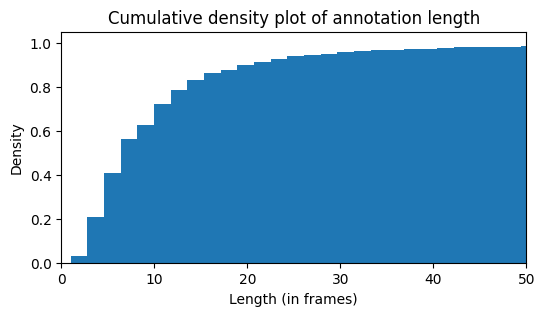

In [7]:
# Showing how long the annotations are (in frames)
plt.figure(figsize=(6,3))
plt.title('Cumulative density plot of annotation length')
plt.xlim(0,50)
plt.hist(ann_lengths, bins = 250, cumulative = True, density = True)
plt.xlabel('Length (in frames)')
plt.ylabel('Density')
plt.show()

In [8]:
print('Mean annotation length', np.median(ann_lengths))

total = smaller + larger + precise
print('Number of annotations, smaller than {0} frames, larger than {0} frames, exactly {0} frames'.format(fixed_length))
print(total, round(smaller/total, 2), round(larger/total, 2), round(precise/total, 2))

Mean annotation length 8.0
Number of annotations, smaller than 10 frames, larger than 10 frames, exactly 10 frames
110435 0.63 0.32 0.05


# Further processing data

In [9]:
top_suffix = '_top' if len(top_signs) != 0 else ''

# Get the list of possible glosses
glosses = list(set(glosses))
print('Unique glosses:', len(glosses))

# https://stackoverflow.com/questions/42320834/sklearn-changing-string-class-label-to-int
# Encode the glosses as numerical
le = preprocessing.LabelEncoder()
fitted = le.fit(glosses)

# Store the transformations of the glosses in a dictionary
# I.e. string label -> int label
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
store_dict(PATHS['label_encoder'].format(top_suffix), dictionary)

Unique glosses: 2894


In [10]:
# New num. annotations for train, test set (filtering by present ratio, removing NaNs)
def prep_X(X):
    X = X.reshape(*X.shape[:-2], -1).astype(np.float32)
    X = np.nan_to_num(X)
    return X

datasets = ['Train', 'Train (no mirror)', 'Validation', 'Test']
total_instances = 0

print('\tdataset \t\t\tdata shape \t\t label shape')
for i in range(len(X)):
    # Convert all to numpy
    X[i] = np.array(X[i])
    y[i] = np.array(y[i])
    # Transform the gloss labels (e.g. 'GEBAREN-A') to numerical (e.g. 123)
    y[i] = fitted.transform(y[i])
    # Make sure data has shape (num_data_points, num_frames, num_features)
    if len(X[i].shape) > 3:
        X[i] = prep_X(X[i])
    # Store as smaller representation to save space, also required later when training 
    # Because otherwise it takes too much memory 
    X[i] = X[i].astype(np.float16) 
    print('{:<25}\t{:<20}\t\t{}'.format(datasets[i], str(X[i].shape), y[i].shape))
    if datasets[i] != 'Train':
        total_instances += X[i].shape[0]
    
X_train, X_train_no_mirr, X_val, X_test = X
y_train, y_train_no_mirr, y_val, y_test = y

	dataset 			data shape 		 label shape
Train                    	(180432, 10, 174)   		(180432,)
Train (no mirror)        	(90216, 10, 174)    		(90216,)
Validation               	(10500, 10, 174)    		(10500,)
Test                     	(9719, 10, 174)     		(9719,)


In [11]:
print('Total number of annotations:', total_instances)
for i in range(1, len(X)):
    print('{}: {}%'.format(datasets[i], round(X[i].shape[0]/total_instances*100)), end = '\t')

Total number of annotations: 110435
Train (no mirror): 82%	Validation: 10%	Test: 9%	

In [12]:
# We want to only keep validation and test examples
# Which have labels that have been seen during training (i.e. are in the train set)
in_train_labels = np.unique(y_train)
val_ind = np.where(np.isin(y_val, in_train_labels))[0]
test_ind = np.where(np.isin(y_test, in_train_labels))[0]
X_val, y_val = X_val[val_ind], y_val[val_ind]
X_test, y_test = X_test[test_ind], y_test[test_ind]
print(X_val.shape, X_test.shape)

(10295, 10, 174) (9585, 10, 174)


# Store datasets

In [13]:
# Save the datasets and labels to their respective numpy files
root = PATHS['data_linguistic'] if only_features else PATHS['data_only_lmrks']
# PATHS format: X or y, type of data (train, val, test), features or not, top X signs 
np.save(root.format('X', 'train', features, top_suffix), X_train)
np.save(root.format('y', 'train', features, top_suffix), y_train)

np.save(root.format('X', 'train_no_mirror', features, top_suffix), X_train_no_mirr)
np.save(root.format('y', 'train_no_mirror', features, top_suffix), y_train_no_mirr)

np.save(root.format('X', 'val', features, top_suffix), X_val)
np.save(root.format('y', 'val', features, top_suffix), y_val)

np.save(root.format('X', 'test', features, top_suffix), X_test)
np.save(root.format('y', 'test', features, top_suffix), y_test) 

In [14]:
labels = load_dict(PATHS['label_encoder'].format(top_suffix))
labels['GEBOREN-A'], labels['AMSTERDAM'], labels['KLAAR-A'], labels['GEBAREN-A'], labels['NU-A']

(836, 182, 1252, 828, 1671)

# Finding highly correlated features

In [16]:
%%time
# Convert the variable length train data to numpy
X_train = np.array(X_train_var_len)
y_train = np.array(y_train_var_len)

# The above code gives us unevenly sized annotations, we can't just reshape
# So to add each frame as a row, we do it in a loop
x = []
for data_point in X_train:
    for frame in data_point:
        x.append(frame)
        
# We mask any NaN values so we can ignore them during later computations
x = np.array(x)
x = ma.masked_invalid(x)
x.shape

<timed exec>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


CPU times: total: 1.64 s
Wall time: 1.65 s


(991431, 174)

In [17]:
%%time
# NOTE: this takes very long to compute (45-60 minutes on the tested hardware)
# This is why we try to avoid recomputing this if possible

# We compute the correlations between the values in the train data
corrs_path = PATHS['masked_corrs'].format(features)

# If we already computed the correlations, reuse them
if os.path.exists(corrs_path):
    print('Corrs being loaded...')
    corrs = np.load(corrs_path)
    cols = range(x.shape[-1])
    # We need to convert to a masked array (can't save it like that)
    if 'masked' in corrs_path:
        corrs = ma.masked_invalid(corrs)
    corrs = list(corrs)
else: # Else, compute the correlations (this takes a while)
    print('Corrs being created...')
    cols = range(x.shape[-1])
    print(x.shape)

    corrs = []
    for col_1 in range(x.shape[-1]-1):
        for col_2 in range(col_1+1, x.shape[-1]):
            print(col_1, end = '\r')
            corr = ma.corrcoef(x[:,col_1], x[:, col_2])[0][1]
            corrs.append((corr, col_1, col_2))
    corrs_np = np.array(corrs)
    np.save(corrs_path, corrs_np)
print('Done.')

Corrs being created...
(991431, 174)


<timed exec>:28: UserWarning: Warning: converting a masked element to nan.


Done.
CPU times: total: 3h 29min 12s
Wall time: 1h 8s


In [18]:
# Continuation of the block above this one
print('Total correlations:\t\t{}'.format(len(corrs)))
num_high_corr = 0
high_corrs = []
removable = []
corr_thresh = 0.9
for corr in corrs:
    if abs(corr[0]) >= corr_thresh:
        corr = [corr[0], int(corr[1]), int(corr[2])]
        high_corrs.append(tuple(corr))
        # Remove the first feature of the high corr. pair
        removable.append(sorted(corr[1:])[-1])
        num_high_corr += 1
print('Num. of correlations >= {}:\t{}'.format(corr_thresh, num_high_corr))
to_remove = list(set(removable))

print('\nTo be removed:', to_remove)
remain = set(cols) - set(to_remove)

print('\nNumber of features we remove:', len(to_remove))
print('Number of features remaining:', len(list(remain)))

print('\n\nHigh correlation tuples:\n')
print(sorted(high_corrs, key = lambda x: x[0], reverse = True))

Total correlations:		15051
Num. of correlations >= 0.9:	156

To be removed: [128, 130, 4, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 145, 23, 24, 147, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 169, 171, 170, 172, 58, 60, 62, 64, 78, 81, 82, 83, 84, 85, 93, 95, 98, 99, 100, 101, 102, 103, 107, 110, 111, 149, 113, 114, 115, 116, 117, 119, 151, 121, 122, 124, 126]

Number of features we remove: 75
Number of features remaining: 99


High correlation tuples:

[(0.9918264022853222, 82, 84), (0.989294890155836, 80, 82), (0.9888438684556139, 11, 13), (0.9844714877917816, 30, 39), (0.9832199152699825, 167, 169), (0.9825041023592658, 32, 41), (0.9820304852600885, 81, 83), (0.9815306782122758, 2, 24), (0.981367857250015, 14, 16), (0.9809075593669315, 98, 100), (0.9795712713413487, 83, 85), (0.9786877836153659, 169, 171), (0.9780112144012227, 4, 30), (0.9780108874448653, 0, 11), (0.9769964252230071, 12, 14), (0.9762570250024152, 101, 103), (0.9730806644789081, 2

In [19]:
# Continuation of the block above this one
print(len(corrs))
num_high_corr = 0
high_corrs = []
removable = []
for corr in corrs:
    if abs(corr[0]) >= 0.80:
        high_corrs.append(corr)
        removable.append(corr[-1])
        num_high_corr += 1
# print(num_high_corr)
# print(list(set(removable)))
# print(sorted(high_corrs, key = lambda x: x[0], reverse = True))

to_remove = np.array(list(set(removable))).astype(np.int64)
remain = set(cols) - set(to_remove)
print('to_remove:', list(to_remove))
print('Number of features we remove:', len(to_remove))
print('Number of features remaining:', len(list(remain)))

15051
to_remove: [1, 2, 4, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 53, 54, 58, 60, 62, 64, 78, 79, 81, 82, 83, 84, 85, 91, 93, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 140, 141, 145, 147, 149, 151, 167, 168, 169, 170, 171, 172, 173]
Number of features we remove: 100
Number of features remaining: 74


In [20]:
# Analyze which features remain
def feature_selection_analysis(num_features, to_remove):
    half_features = round(num_features/2) - 1
    print(half_features)
    rem = set(range(x.shape[-1])) - set(to_remove)
    print('Remain length:', len(rem))
    rem_first = [r for r in sorted(rem) if r <= half_features]
    rem_second = [r-(half_features+1) for r in sorted(rem) if r > half_features]
    print('Remaining of left hand:')
    print(rem_first, '({} features)'.format(len(rem_first)))
    print('Remaining of right hand:')
    print(rem_second, '({} features)'.format(len(rem_second)))

    print('Extra features right hand:', sorted(set(rem_second) - set(rem_first)))
    print('Extra features left hand:', sorted(set(rem_first) - set(rem_second)))
    
    print('Same for both hands:', sorted(set(rem_second) & set(rem_first)))
# We use cols to get the number of features
feature_selection_analysis(len(cols), to_remove)

86
Remain length: 74
Remaining of left hand:
[0, 3, 5, 7, 10, 25, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 59, 61, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 80, 86] (35 features)
Remaining of right hand:
[0, 1, 2, 3, 5, 7, 10, 22, 25, 33, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 59, 61, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79] (39 features)
Extra features right hand: [1, 2, 22, 33, 78, 79]
Extra features left hand: [80, 86]
Same for both hands: [0, 3, 5, 7, 10, 25, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 59, 61, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]


In [21]:
# We round the values in the correlations, then remove masked values because we can't count them
# Then we print a counter of the (rounded) correlations
corrs_round = np.ma.array([np.round(c[0], 1) for c in corrs])
corrs_round_not_masked = corrs_round[~corrs_round.mask]
print(Counter(corrs_round_not_masked))

Counter({0.0: 9527, 0.1: 1395, -0.1: 817, 0.7: 533, 0.6: 508, 0.2: 420, 0.8: 392, 0.5: 260, 0.9: 240, -0.2: 206, 0.3: 192, 0.4: 85, 1.0: 53, -0.3: 46, -0.4: 24, -0.5: 3, -0.6: 3, -0.7: 2})


D:\Anaconda\envs\thesis\lib\site-packages\numpy\ma\core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
